In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection as fdr

In [ ]:
# Initialize
np.random.seed(42)
PATH = '...'
cat = 'DEL'

# Initialize functions
scaler = StandardScaler()

Load PLS scores

In [ ]:
# Load covariates
df_cov = pd.read_csv(PATH + '....csv')
# Load PLS results
pls_results = pd.read_csv(PATH + '....csv')
ndim = 3
x_score_ctrl = pls_results.loc[pls_results['SampleID'].isin(df_cov['SampleID']), ['x_score_1', 'x_score_2', 'x_score_3']]
y_score_ctrl = pls_results.loc[pls_results['SampleID'].isin(df_cov['SampleID']), ['y_score_1', 'y_score_2', 'y_score_3']]

# Prepare PLS scores dataframe
df_score = pd.DataFrame(data=np.hstack((x_score_ctrl, y_score_ctrl)),
                        columns=['x_score_1', 'x_score_2', 'x_score_3',
                                 'y_score_1', 'y_score_2', 'y_score_3'],
                        index=df_cov['SampleID'])

df_score.reset_index(inplace=True, drop=False)
df_score.rename(columns={'index': 'SampleID'}, inplace=True)

Prepare ethnicity data

In [ ]:
# Effect of ethnicity
cols_to_load = ['subjectkey', 'eventname', 'sex', 'interview_date', 'interview_age', 'demo_race_a_p___10',
                'demo_race_a_p___11', 'demo_race_a_p___12', 'demo_race_a_p___13', 'demo_race_a_p___14',
                'demo_race_a_p___15', 'demo_race_a_p___16', 'demo_race_a_p___17', 'demo_race_a_p___18',
                'demo_race_a_p___19', 'demo_race_a_p___20', 'demo_race_a_p___21', 'demo_race_a_p___22',
                'demo_race_a_p___23', 'demo_race_a_p___24', 'demo_race_a_p___25']
eth_cols = cols_to_load[5:]
ethnicity = ['White', 'Black/African American', 'American Indian, Native America', 'Alaska Native',
             'Native Hawaiian', 'Guamanian', 'Samoan', 'Other Pacific Islander', 'Asian Indian',
             'Chinese', 'Filipino', 'Japanese', 'Korean', 'Vietnamese', 'Other Asian', 'Other']
# Load demographic data
df_dem = pd.read_csv(PATH + '.../pdem02.txt', sep='\t', usecols=cols_to_load)
df_dem = df_dem.drop(df_dem.index[0], axis=0)  # Drop the first row
df_dem['sex'] = df_dem['sex'].replace({'M': 0, 'F': 1})
df_dem.rename(columns={'subjectkey': 'SampleID'}, inplace=True)
df_dem[eth_cols] = df_dem[eth_cols].astype('int')  # Convert to int

In [ ]:
# Merge demographic data with PLS scores
df_annot = pd.merge(df_score, df_dem, on='SampleID', how='inner')  # Inner join with PLS scores
df_annot = pd.merge(df_annot, df_cov, on=['SampleID', 'sex', 'interview_age'], how='inner') # Inner join with covariates

Test for association between PLS scores and various covariates (ethnicity, sex, age, scanner, PC1-10)

In [ ]:
# ANOVA for scanner
pvals_scan_x = []
pvals_scan_y = []
for i in range(ndim):
    # ANOVA for x_score
    df = pd.DataFrame({'scanner': df_annot.loc[:, 'scanner'].values,
                       'score': df_annot.loc[:, 'x_score_'+str(i+1)].values})
    # get ANOVA table as R like output
    model = ols('score ~ C(scanner)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pvals_scan_x.append(anova_table.iloc[0, 3])  # p-value for scanner effect

    # ANOVA for y_score
    df = pd.DataFrame({'scanner': df_annot.loc[:, 'scanner'].values,
                       'score': df_annot.loc[:, 'y_score_'+str(i+1)].values})
    # get ANOVA table as R like output
    model = ols('score ~ C(scanner)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pvals_scan_y.append(anova_table.iloc[0, 3])


In [ ]:
# ANOVA for ethinicity
pvals_eth_x = []
pvals_eth_y = []
for i in range(ndim):
    sub_eth = []
    for j, eth in enumerate(eth_cols):
        sub_eth.append(df_annot.loc[:, eth].values*(j+1))
    sub_eth = np.array(sub_eth).T
    # Drop rows with more then 1 value
    idx = np.where(np.sum(sub_eth > 0, axis=1) == 1)[0]
    sub_eth_red = sub_eth[idx, :]
    sub_eth_red = np.sum(sub_eth_red, axis=1)

    # ANOVA for x_score
    df = pd.DataFrame({'eth': sub_eth_red, 'score': df_annot.loc[idx, 'x_score_'+str(i+1)].values})
    # get ANOVA table as R like output
    model = ols('score ~ C(eth)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pvals_eth_x.append(anova_table.iloc[0, 3])

    # ANOVA for y_score
    df = pd.DataFrame({'eth': sub_eth_red, 'score': df_annot.loc[idx, 'y_score_'+str(i+1)].values})
    # get ANOVA table as R like output
    model = ols('score ~ C(eth)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    pvals_eth_y.append(anova_table.iloc[0, 3])

In [ ]:
# T-test for sex
pvals_sex_x = []
pvals_sex_y = []
for i in range(ndim):
    model = stats.ttest_ind(df_annot.loc[df_annot.loc[:, 'sex'].values==0, 'x_score_'+str(i+1)].values,
                            df_annot.loc[df_annot.loc[:, 'sex'].values==1, 'x_score_'+str(i+1)].values,
                            equal_var=True)
    pvals_sex_x.append(model[1])

    model = stats.ttest_ind(df_annot.loc[df_annot.loc[:, 'sex'].values==0, 'y_score_'+str(i+1)].values,
                            df_annot.loc[df_annot.loc[:, 'sex'].values==1, 'y_score_'+str(i+1)].values,
                            equal_var=True)
    pvals_sex_y.append(model[1])

In [ ]:
# Correlation with age
pvals_age_x = []
pvals_age_y = []
for i in range(ndim):
    model = stats.pearsonr(df_annot.loc[:, 'interview_age'].values,
                           df_annot.loc[:, 'x_score_'+str(i+1)].values)
    pvals_age_x.append(model[1])
    
    model = stats.pearsonr(df_annot.loc[:, 'interview_age'].values,
                           df_annot.loc[:, 'y_score_'+str(i+1)].values)
    pvals_age_y.append(model[1])

In [ ]:
# Correlation with genetic PCs
pvals_pc_x = []
pvals_pc_y = []
for i in range(ndim):
    tmp_x = []
    tmp_y = []
    for j in range(10): # 10 genetic PCs
        model = stats.pearsonr(df_annot.loc[:, 'PC'+str(j+1)].values,
                               df_annot.loc[:, 'x_score_'+str(i+1)].values)
        tmp_x.append(model[1])

        model = stats.pearsonr(df_annot.loc[:, 'PC'+str(j+1)].values,
                               df_annot.loc[:, 'y_score_'+str(i+1)].values)
        tmp_y.append(model[1])
    pvals_pc_x.append(tmp_x)
    pvals_pc_y.append(tmp_y)

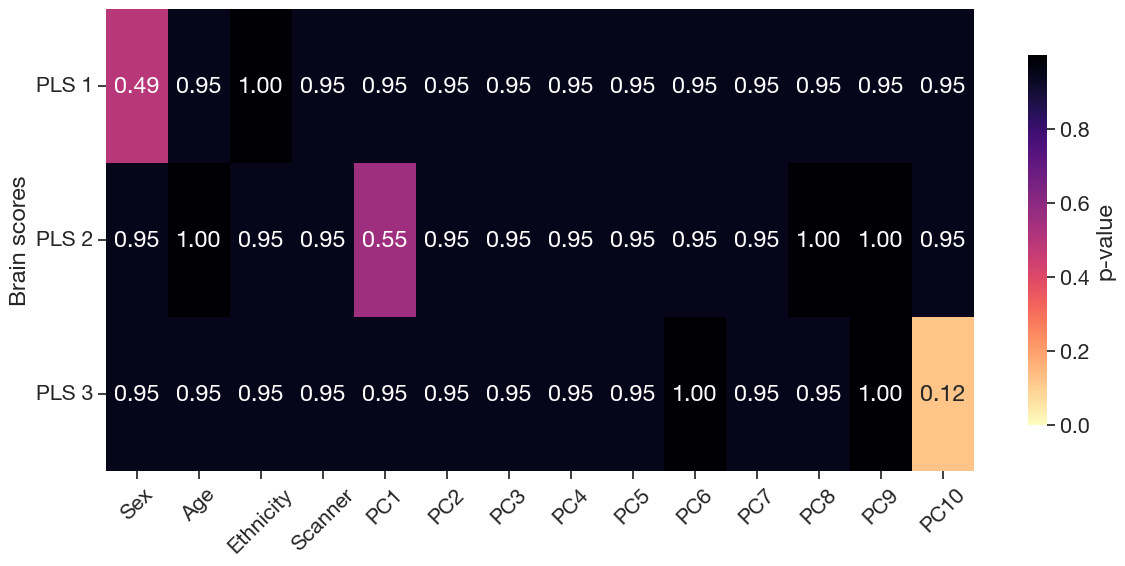

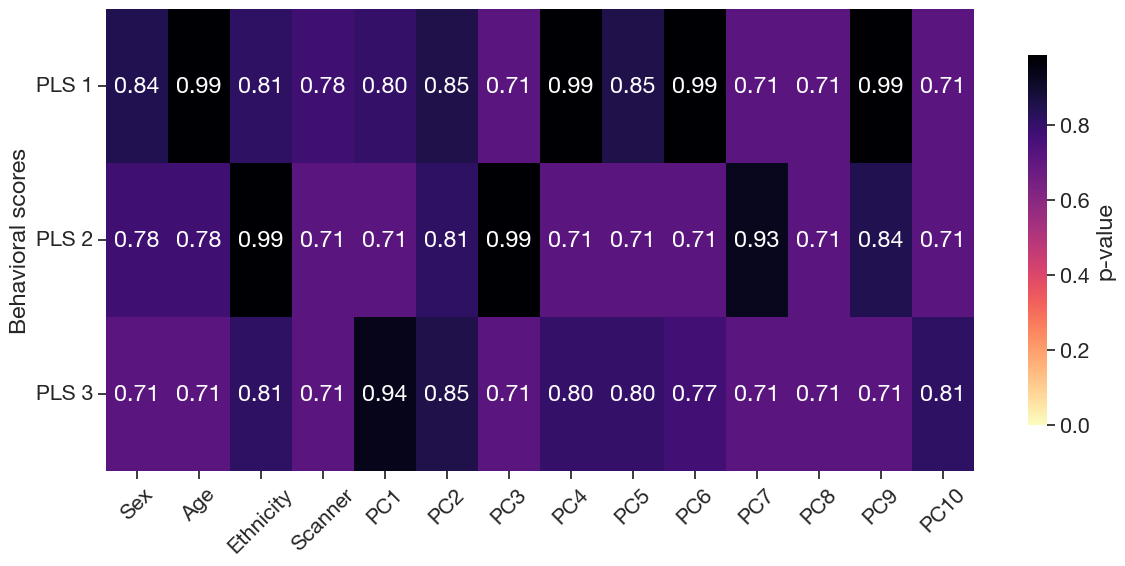

In [ ]:
# Get p-values for each effect and correct for multiple comparisons
# Brain scores
pvals = np.vstack((pvals_sex_x, pvals_age_x, pvals_eth_x, pvals_scan_x, np.array(pvals_pc_x).T))
pvals = np.reshape(fdr(np.reshape(pvals, -1), alpha=0.05)[1], pvals.shape)

fig, ax = plt.subplots(1, figsize=(14, 6))
sns.heatmap(pvals.T, cmap='magma_r', annot=True, fmt='.2f', ax=ax, vmin=0,
            cbar_kws={'label': "p-value", 'shrink': 0.8} )
ax.set_yticklabels(['PLS 1', 'PLS 2', 'PLS 3'], rotation=0)
ax.set_xticklabels(['Sex', 'Age', 'Ethnicity','Scanner', 'PC1', 'PC2', 'PC3',
                    'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                    rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Brain scores')
plt.show()

# Get p-values for each effect and correct for multiple comparisons
# Behavioral scores
pvals = np.vstack((pvals_sex_y, pvals_age_y, pvals_eth_y, pvals_scan_y, np.array(pvals_pc_y).T))
pvals = np.reshape(fdr(np.reshape(pvals, -1), alpha=0.05)[1], pvals.shape)

fig, ax = plt.subplots(1, figsize=(14, 6))
sns.heatmap(pvals.T, cmap='magma_r', annot=True, fmt='.2f', ax=ax, vmin=0,
            cbar_kws={'label': "p-value", 'shrink': 0.8} )
ax.set_yticklabels(['PLS 1', 'PLS 2', 'PLS 3'], rotation=0)
ax.set_xticklabels(['Sex', 'Age', 'Ethnicity','Scanner', 'PC1', 'PC2', 'PC3',
                    'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],
                    rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Behavioral scores')
plt.show()
